# Regression Basics
[GPflow](https://www.gpflow.org/) is a Python library used for Gaussian process regression. It is implemented using
[TensorFlow](https://www.tensorflow.org/).<br>

This notebook will run you through basic GPflow regression, as well as how it is adapted in BNQDflow.<br>
<br>

## Regression in GPflow
All GP regression models in GPflow inherit from the [GPModel](https://gpflow.readthedocs.io/en/develop/gpflow/models/index.html#gpflow-models-gpmodel)
class. All implementations can be found in the [documentation](https://gpflow.readthedocs.io/en/develop/gpflow/models/index.html),
but chances are you'll mostly be using [GPR](https://gpflow.readthedocs.io/en/develop/gpflow/models/index.html#gpflow-models-gpr),
which is the most basic implementation of a GP regression model.<br>

The methods in GPModels mainly consist of two types:
  1. Methods related to probabilistic statistics. Such as the likelihood of the data, or the probability density at a
     certain coordinate.
  2. Methods related to predictions. Such as the prediction of the latent function (i.e. the function that is assumed to
     have generated the data), or the prediction of unseen data points.
     
Before we can do any regression, we first need to generate some data.

### Dataset Generation

In [1]:
import numpy as np

sigma = 0.5  # Standard deviation
n = 100  # Number of data points

x = np.linspace(-3, 3, n)  # Evenly distributed x values

f = 0.8 * np.sin(x) + 0.2 * x ** 2 + 0.2 * np.cos(x / 4)  # Underlying function
y = np.random.normal(f, sigma, size=n)  # y values as the underlying function + noise

### Initializing a GPR
The signature of the GPR's constructor looks like this:
```
data: RegressionData,
kernel: Kernel,
mean_function: Optional[MeanFunction] = None,
noise_variance: float = 1.0,
```
Where `RegressionData` is a tuple consisting of a list of x-values and a list of corresponding y-values.<br>

For the `kernel`, several options exist (and all can be found in the [documentation](https://gpflow.readthedocs.io/en/develop/gpflow/kernels/index.html)),
but for now we'll use a squared exponential kernel, which should easily be able to fit the data (though this isn't
necessarily a good thing).<br>

The `mean_function` is a specification of the shape of the function that the GP regression goes through. By default,
the [Zero](https://gpflow.readthedocs.io/en/develop/gpflow/mean_functions/index.html#gpflow-mean-functions-zero) mean
function is used. Other options include linear, constant, and any combination summed or multiplied with each other.<br>

The `noise_variance` is the initial value of the variance over the data points.<br>

We'll just specify the kernel and the data for now.

In [2]:
import gpflow as gf

# We import some of GPflow's classes separately to avoid having to type as much
from gpflow.kernels import SquaredExponential, Constant, Linear, Periodic, Cosine, Exponential
from gpflow.models import GPR

# Since GPflow uses TensorFlow, the data needs to be in a format that TensorFlow can work with.
# This line turns the x and y values into matrices of shape (n, 1). So basically a matric with only one column
data = (x[:, None], y[:, None])
kernel = SquaredExponential()

gpm = GPR(data, kernel)

### Training a GPR
Next, we'll have to fit the regression to the input data.<br>

GPflow offers three main [optimizers](https://gpflow.readthedocs.io/en/develop/gpflow/optimizers/index.html), with the
Scipy optimizer offering different [methods](https://docs.scipy.org/doc/scipy/reference/optimize.html). We'll use the
Scipy optimizer with the default method.<br>

In order for the optimizer to fit the parameters to the data, we need to call the minimize() method and specify two
arguments:
  1. A function whose result should be minimized.
  2. A list of parameters/variables that can be altered to change the result of the function.

For the function, we'll use `GPR._training_loss()` (which is simply the negative log likelihood of the data). And for the
list of parameters/variables, we'll use `GPR.trainable_variables`. The alternative would be `GPR.trainable_parameters`
(which is a list of constrained and unconstrained values of the variables), but this tends to result in a TensorFlow
error related to non-invertible matrices.<br>

If you ever wish to exclude a variable of the training step, you can simply use `gpflow.utilities.set_trainable(<variable>, False)`.
This will exclude the variable from the list of trainable variables.

In [3]:
from gpflow.optimizers import Scipy

optimizer = Scipy()

optimizer.minimize(gpm._training_loss, gpm.trainable_variables)

      fun: 78.7099701129573
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.47786456e-05,  2.45599770e-06, -3.76627349e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 17
   status: 0
  success: True
        x: array([ 1.82310785,  3.15566888, -1.37370791])

### Inspecting the GPR
Any `gpflow.Module` implementation (that includes `GPModel` objects) can be inspected using `gpflow.utilities.print_summary()`.
This will print information about all contained variables/parameters (such as the kernel's lengthscale, or the variance
of the likelihood).

In [4]:
gf.utilities.print_summary(gpm)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.1974   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.97284  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.225675 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

### Likelihood of the Data
Now that the model is trained, we can obtain a representative measure of the likelihood of the data. For GPModels, the
log likelihood can be obtained with `GPModel.maximum_log_likelihood_objective()`, and the log posterior density can be
obrained with `GPModel.log_posterior_density()` (which estimates the log marginal likelihood if the log likelihood is
defined sensibly). Addidionally, the GPR class also has its own `log_marginal_likelihood()` method. But this is exactly
the same as its definition for the `maximum_log_likelihood_objective()`.

In [5]:
print(f"log likelihood: {gpm.maximum_log_likelihood_objective()}\n"
      f"log marginal likelihood: {gpm.log_posterior_density()}\n"
      f"GPR's log marginal likelihood: {gpm.log_marginal_likelihood()}")

log likelihood: -78.7099701129573
log marginal likelihood: -78.7099701129573
GPR's log marginal likelihood: -78.7099701129573


### Predictions of the GPR
After the training step, the GPR will have obtained a representation of the latent function, as well as the likelihood
of unseen data points. The prediction of the latent function can be accessed with `GPR.predict_f()`, and the likelihood
of unseen data points with `GPR.predict_y()`. You can also produce samples of the latent function with `GPR.predict_f_samples()`.

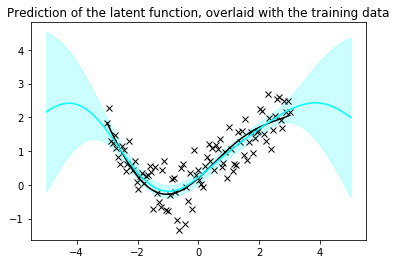

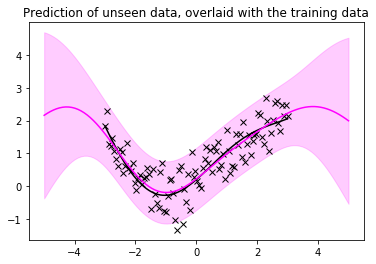

In [6]:
import matplotlib.pyplot as plt

# Function used to plot the training data, as well as the underlying function that generated them
def plot_training_data():
    plt.plot(x, f, c='k')
    plt.plot(x, y, linestyle='none', marker='x', color='k')

n_samples = 100
x_min, x_max = (-5, 5)
# x-values to predict for
x_samples = np.linspace(x_min, x_max, n_samples)

# Lists of mean and variance values of the latent function at the input points
mean_f, var_f = gpm.predict_f(x_samples[:, None])
# Lists of mean and variance values of unseen data at the input points
mean_y, var_y = gpm.predict_y(x_samples[:, None])

plot_training_data()
# Plotting the predicted mean of the latent function
plt.plot(x_samples, mean_f[:, 0], c='cyan')
# Plotting the 95% confidence interval of the latent function
plt.fill_between(x_samples, mean_f[:, 0] - 1.96 * np.sqrt(var_f[:, 0]), mean_f[:, 0] + 1.96 * np.sqrt(var_f[:, 0]),
                 color='cyan', alpha=0.2)
plt.title('Prediction of the latent function, overlaid with the training data')
plt.show()

plot_training_data()
# Plotting the predicted mean of the latent function
plt.plot(x_samples, mean_y[:, 0], c='magenta')
# Plotting the 95% confidence interval of the latent function
plt.fill_between(x_samples, mean_y[:, 0] - 1.96 * np.sqrt(var_y[:, 0]), mean_y[:, 0] + 1.96 * np.sqrt(var_y[:, 0]),
                 color='magenta', alpha=0.2)
plt.title('Prediction of unseen data, overlaid with the training data')
plt.show()

As can be seen in the first plot, the latent function that generated the data is indeed within the 95% confidence
interval of the prediction of the latent function. Similarly, the vast majority of the data points are within the 95%
confidence interval of the prediction of unseen data points.

## Regression in BNQDflow
Now that we've done some GP regression in GPflow "by hand", we can move to how it's done in BNQDflow.<br>

### The GPMContainer Class
Since BNQDflow is a library used for quasi-experimental designs, it needs to somehow be able to compute probabilistic
statistics of models with more than one GPModel. This is done via the `bnqdflow.models.GPMContainer` class. Whose
container's signature looks like this:
```
regression_source: Union[Kernel, GPModel, List[GPModel]],
data_list: Optional[List[RegressionData]] = None,
intervention_points: Optional[List[Tensor]] = None,
share_params: Optional[bool] = True
```
The `regression_source` can either be a list of GPModels (in which case the GPMContainer simply wraps around the list),
or a single Kernel or GPModel (in which case a list is generated from that model or kernel).<br>

If the `regression_source` isn't a list, some list of `RegressionData` must be provided, in order to generate a list of
GPModels. The number of models will be determined by the numer of `RegressionData` objects in the `data_list`.<br>

If the `GPMContainer` contains more than one model, some list of intervention points must be provided. This determines
which GPModel is used for the regression at what x-range. The length of this list must be one lower than the number of
contained GPModels. For example, if it contains two GPModels, one whose data ranges from x=-3 to x=0 and one whose data
ranges from x=0 to x=3, then there must be one intervention point (likely at x=0). The intervention point(s) are mainly
used for plotting and by an Analysis for the calculation of the effect size.<br>

The `share_params` argument determines whether or not the contained models used the same hyper parameters. The default
`True`, since this generally results in more representative differences between models, in regards to the effect size
and likelihood.<br>

Many methods related to probabilistic statistics are adjusted to support the wrapping of multiple GPModels. These
include:
  1. `maximum_log_likelihood_objective`
  2. `log_posterior_density`
  3. `_training_loss`
  
We'll start with making a GPMContainer that functions the same as the GPR we defined above.

In [7]:
import bnqdflow as bf

from bnqdflow.models import GPMContainer

# BNQDflow ensures the data is in the proper format for TensorFlow, so you don't have to do it yourself anymore
data = (x, y)

# However, the data does need to be passed as a list with a single element
gpc = GPMContainer(SquaredExponential(), [data])

### Training a GPMContainer
Training can now by done by simply calling the `.train()` method. By default, the Scipy optimizer will be used, but you
can also specify a different optimizer with the key argument `optimizer`. Additionally, a summary of the GPMContainer
will be printed after training by default. Though this can also be disabled via `verbose=False`.

In [8]:
gpc.train()

╒════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                       │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPMContainer.models[0].kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.1974   │
├────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPMContainer.models[0].kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.97284  │
├────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPMContainer.models[0].likelihood.variance │ Parameter │ Softplus +

### Predictions of a GPMContainer
Since a GPMContainer contains multiple GPModels, one has to give a _list_ of `RegressionData` instead of just a single
object. The length of the list should correspond to the number of contained models.<br>

However, you don't need to predict anything in order to plot the regression(s). This can simply be done with
`GPMContainer.plot_regression()`. This method takes several optional arguments that determine what the plot looks like.
Such as the number of x-samples, whether to use predict_f or predict_y, the padding of the plot, and whether or not to
plot the training data.

mean shape: (100, 1)
var shape: (100, 1)


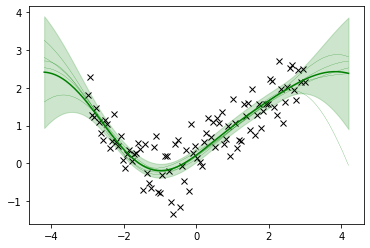

In [9]:
# This bit of code is unnecessary for plotting. It simply serves as an example.
x_samples = np.linspace(-5, 5, 100)
example_prediction_list = gpc.predict_f([x_samples])
for mean, var in example_prediction_list:
    print(f"mean shape: {np.shape(mean)}\nvar shape: {np.shape(var)}")
    
# The actual plotting step
gpc.plot_regression()
plt.show()

### GPMContainer with Multiple GPModels
Let's now try splitting up the data and using a GPMContainer with two models.

╒════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                       │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPMContainer.models[0].kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.45087  │
│ GPMContainer.models[1].kernel.variance     │           │                  │         │             │         │         │          │
├────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPMContainer.models[0].kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.00051  │
│ GPMContainer.models[1].kernel.lengthscales │           │           

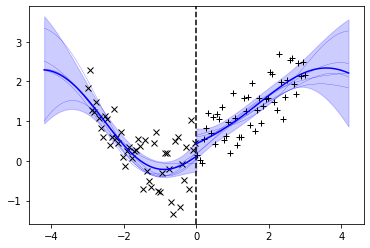

In [10]:
ip = 0.0  # single intervention point

# Data used by the control model (pre-intervention)
x1 = x[x <= ip]
y1 = y[x <= ip]

# Data used by the (post-)intervention model
x2 = x[x > ip]
y2 = y[x > ip]

gpc2 = GPMContainer(SquaredExponential(), [(x1, y1), (x2, y2)], intervention_points=[ip])
gpc2.train()
gpc2.plot_regression()

### ContinuousModel and DiscontinuousModel
For the sake of simplicity, BNQDfloq also has two classes that extend the `GPMContainer` class: `ContinuousModel`
and `DiscontinuousModel`. `ContinuousModel` only takes one `RegressionData` object and no list of intervention
points. Additionally, for any methods related to prediction, it doesn't use lists, so you don't have to work with lists
with one element (as we had to in the previous steps).`DiscontinuousModel` takes a list of two `RegressionData` objects
and a single intervention point.

╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ ContinuousModel.models[0].kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.1974   │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ ContinuousModel.models[0].kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.97284  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ ContinuousModel.models[0].likelihood.variance 

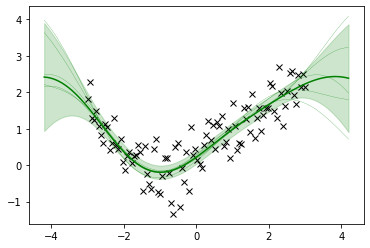

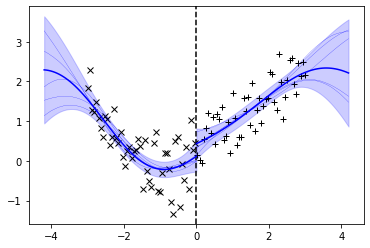

In [11]:
from bnqdflow.models import ContinuousModel, DiscontinuousModel

cm = ContinuousModel(SquaredExponential(), (x, y))
dm = DiscontinuousModel(SquaredExponential(), [(x1, y1), (x2, y2)], ip)

cm.train()
dm.train()

cm.plot_regression()
plt.show()
dm.plot_regression()
plt.show()
